In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [5]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

True

In [6]:
%autoreload

data, test_data = mre_pinn.data.load_bioqic_dataset('../data/BIOQIC', 'fem_box', xyz_slice='2D')
data

Loading ../data/BIOQIC/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128
Loading ../data/BIOQIC/fem_box_ground_truth.npy
     <class 'numpy.ndarray'> (6, 10, 80, 100) complex128
Multi frequency 2D
<xarray.Dataset>
Dimensions:    (frequency: 6, x: 80, y: 100, component: 2)
Coordinates:
  * frequency  (frequency) float64 50.0 60.0 70.0 80.0 90.0 100.0
  * x          (x) float64 0.0 0.001 0.002 0.003 ... 0.076 0.077 0.078 0.079
  * y          (y) float64 0.0 0.001 0.002 0.003 ... 0.096 0.097 0.098 0.099
    z          float64 0.0
  * component  (component) <U1 'z' 'y'
Data variables:
    u          (frequency, x, y, component) complex128 (7.435908284487881e-15...
    mu         (frequency, x, y) complex128 (3000+314.1592653589793j) ... (30...


<xarray.Dataset>
Dimensions:    (frequency: 6, x: 80, y: 100, component: 2)
Coordinates:
  * frequency  (frequency) float64 50.0 60.0 70.0 80.0 90.0 100.0
  * x          (x) float64 0.0 0.001 0.002 0.003 ... 0.076 0.077 0.078 0.079
  * y          (y) float64 0.0 0.001 0.002 0.003 ... 0.096 0.097 0.098 0.099
    z          float64 0.0
  * component  (component) <U1 'z' 'y'
Data variables:
    u          (frequency, x, y, component) complex128 (7.435908284487881e-15...
    mu         (frequency, x, y) complex128 (3000+314.1592653589793j) ... (30...
    Lu         (frequency, x, y, component) complex128 (-0.001673382030335908...
    Mu         (frequency, x, y) complex128 (2832.4756903541183-2515.88388301...

<IPython.core.display.Javascript object>


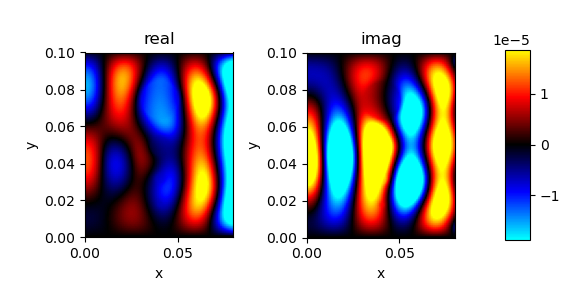

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


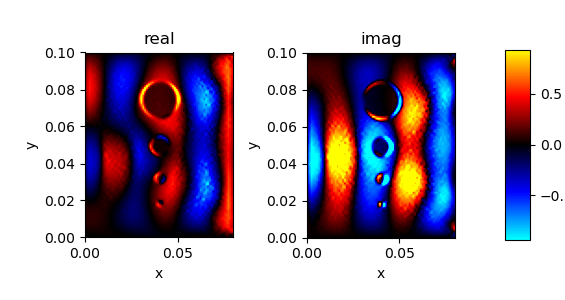

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


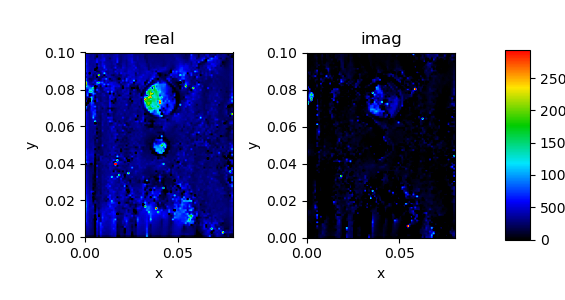

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


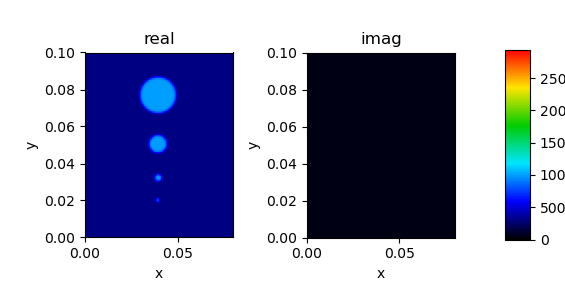

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [71]:
%autoreload

# configure color maps
pct = 95 

w_map = mre_pinn.visual.wave_color_map()
w_max = np.percentile(np.abs(data.u), pct) * 1.1
wave_kws = dict(cmap=w_map, vmin=-w_max, vmax=w_max)

L_max = np.percentile(np.abs(data.Lu), pct) * 1.1
laplace_kws = dict(cmap=w_map, vmin=-L_max, vmax=L_max)

e_map = mre_pinn.visual.elast_color_map()
e_max = np.percentile(np.abs(data.mu), pct) * 5
elast_kws = dict(cmap=e_map, vmin=0, vmax=e_max)

# display true wave field and elastogram
mre_pinn.visual.XArrayViewer(data.u,  col='part', **wave_kws)
mre_pinn.visual.XArrayViewer(data.Lu, col='part', **laplace_kws)
mre_pinn.visual.XArrayViewer(data.Mu.mean('frequency'), col='part', **elast_kws)
mre_pinn.visual.XArrayViewer(data.mu.mean('frequency'), col='part', **elast_kws)

In [72]:
# convert to vector/scalar fields and coordinates
x  = data.u.field.points().astype(np.float32)
u  = data.u.field.values().astype(np.complex64)
mu = data.mu.field.values().astype(np.complex64)

print('x ', type(x), x.shape, x.dtype)
print('u ', type(u), u.shape, u.dtype)
print('mu', type(mu), mu.shape, mu.dtype)

x  <class 'numpy.ndarray'> (48000, 3) float32
u  <class 'numpy.ndarray'> (48000, 2) complex64
mu <class 'numpy.ndarray'> (48000, 1) complex64


In [73]:
%autoreload

# initialize the PDE, geometry, and boundary conditions
pde = mre_pinn.pde.WaveEquation.from_name('Helmholtz', detach=True)
#geom = deepxde.geometry.Hypercube(x.min(axis=0), x.max(axis=0))
geom = deepxde.geometry.PointCloud(x)
bc = mre_pinn.fields.VectorFieldBC(x, u)

In [76]:
%autoreload

# define model architecture

net = mre_pinn.model.MREPINN(
    input=x,
    outputs=[u, mu],
    omega0=32,
    n_layers=3,
    n_hidden=128,
    activ_fn='s',
    parallel=True,
    dense=True,
    dtype=torch.float32
)

model = mre_pinn.training.MREPINNModel(
    net, pde, geom, bc,
    batch_size=128,
    num_domain=0,
    num_boundary=0,
    train_distribution='Sobol',
    anchors=x
)

net

MREPINN(
  (0): InputScaler()
  (1): Parallel(
    (0): FFNN(
      (linear0_sin): Linear(in_features=3, out_features=128, bias=True)
      (linear1_sin): Linear(in_features=131, out_features=128, bias=True)
      (linear2): Linear(in_features=259, out_features=4, bias=True)
    )
    (1): FFNN(
      (linear0_sin): Linear(in_features=3, out_features=128, bias=True)
      (linear1_sin): Linear(in_features=131, out_features=128, bias=True)
      (linear2): Linear(in_features=259, out_features=2, bias=True)
    )
  )
  (2): RealToComplex()
  (3): OutputScaler()
)

In [ ]:
# investigate complex derivatives
break
x = np.linspace(-np.pi, np.pi, 100)

a = torch.ones(1).requires_grad_(True)
b = torch.ones(1).requires_grad_(True)

def f(a, b):
    x = torch.linspace(-np.pi, np.pi, 100)
    y = torch.complex(a * torch.cos(x), b * torch.sin(x))
    return torch.norm(y)

L = f(a, b)
L_a = torch.autograd.grad(L, a, grad_outputs=torch.ones_like(L), create_graph=True)[0][0]
L_b = torch.autograd.grad(L, b, grad_outputs=torch.ones_like(L), create_graph=True)[0][0]

print(L)
print(L_a, L_b)

def diff(f, a, b, da=0, db=0):
    return (f(a + da, b + db) - f(a - da, b - db)) / (2 * (da + db))

d_a = diff(f, a, b, da=1e-3)
d_b = diff(f, a, b, db=1e-3)

print(d_a, d_b)

a, b

In [75]:
# descriptive statistics

%autoreload

kws = dict(axis=0, keepdims=True)

# standardize input to [-1, 1]
x_loc = x.mean(**kws)
x_scale = (x.max(**kws) - x.min(**kws)) / 2
print('x', x_loc, x_scale)

# avoid division by zero
x_scale[x_scale == 0] = 1
x_s = (x - x_loc) / x_scale

# test forward pass
u_pred, lu_pred, pde_res, mu_pred = model.predict(x, batch_size=128)

u_pred = u_pred.detach().cpu().numpy()
lu_pred = lu_pred.detach().cpu().numpy()
mu_pred = mu_pred.detach().cpu().numpy()

# normalize outputs via mean and std
u_loc = u.mean(**kws)
u_scale = u.std(**kws)
print('u', u_loc, u_scale)

u_s = (u - u_loc) / u_scale
u_pred_s = (u_pred - u_loc) / u_scale

mu_loc = mu.mean(**kws)
mu_scale = mu.std(**kws)
print('mu', mu_loc, mu_scale)

mu_s = (mu - mu_loc) / mu_scale
mu_pred_s = (mu_pred - mu_loc) / mu_scale

# compute laplacian statistics
lu_loc = lu_pred.mean(**kws)
lu_scale = lu_pred.std(**kws)
print('lu', lu_loc, lu_scale)

# display input and output distributions

def hex_to_rgb(h):
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

def plot_hist(ax, a, xlabel, hue=None):
    if np.iscomplexobj(a):
        a = mre_pinn.utils.as_real(a)
    bin_width = (a.max() - a.min()) / 20
    for a, hue in zip(a.T, hue):
        bins = np.arange(a.min(), a.max() + bin_width, bin_width)
        color = next(ax._get_lines.prop_cycler)["color"]
        ax.hist(a, bins=bins, label=hue, edgecolor='0.2', fc=color + '80')
    ax.set_xlabel(xlabel)
    ax.legend(frameon=True, edgecolor='0.2')

fig, axes = plt.subplots(6, 2, figsize=(8, 10))

ndim = len(data.u.field.spatial_dims)
x_hues = ['$\omega$', '$x$', '$y$', '$z$'][:ndim+1]
plot_hist(axes[0,0], x,   hue=x_hues, xlabel='x')
plot_hist(axes[0,1], x_s, hue=x_hues, xlabel='x_s')

u_hues = ['$u_z$', '$u_y$', '$u_x$'][:ndim]
u_hues = [p.format(h) for h in u_hues for p in ['Re[{}]', 'Im[{}]']]
plot_hist(axes[1,0], u_pred,   hue=u_hues, xlabel='u_pred')
plot_hist(axes[1,1], u_pred_s, hue=u_hues, xlabel='u_pred_s')

plot_hist(axes[2,0], u,   hue=u_hues, xlabel='u_true')
plot_hist(axes[2,1], u_s, hue=u_hues, xlabel='u_true_s')

mu_hues = ['Re[$\mu$]', 'Im[$\mu$]']
plot_hist(axes[3,0], mu_pred,   hue=mu_hues, xlabel='mu_pred')
plot_hist(axes[3,1], mu_pred_s, hue=mu_hues, xlabel='mu_pred_s')

plot_hist(axes[4,0], mu,   hue=mu_hues, xlabel='mu_true')
plot_hist(axes[4,1], mu_s, hue=mu_hues, xlabel='mu_true_s')

lu_hues = ['$\\nabla^2 u_z$', '$\\nabla^2 u_y$', '$\nabla^2 u_x$'][:ndim]
#lu_hues = [p.format(h) for h in lu_hues for p in ['Re[{}]', 'Im[{}]']]
plot_hist(axes[5,0], lu_pred, hue=lu_hues, xlabel='lu_pred')

fig.tight_layout()

x [[7.500000e+01 3.949972e-02 4.949943e-02]] [[25.      0.0395  0.0495]]


ValueError: too many values to unpack (expected 4)

Compiling model...
'compile' took 0.000210 s

Training model...



<IPython.core.display.Javascript object>


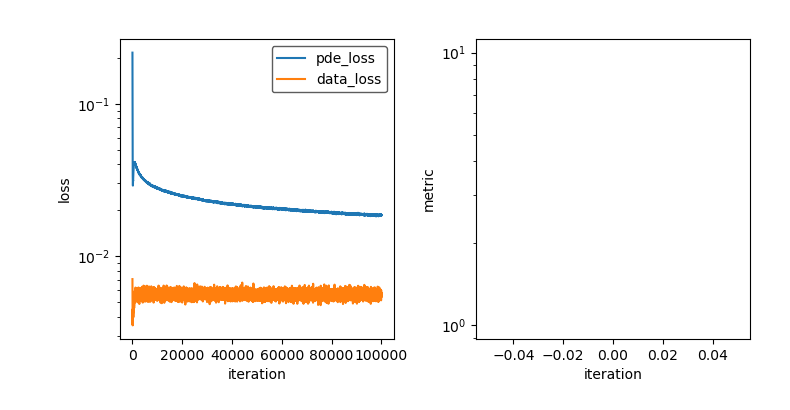

<IPython.core.display.Javascript object>


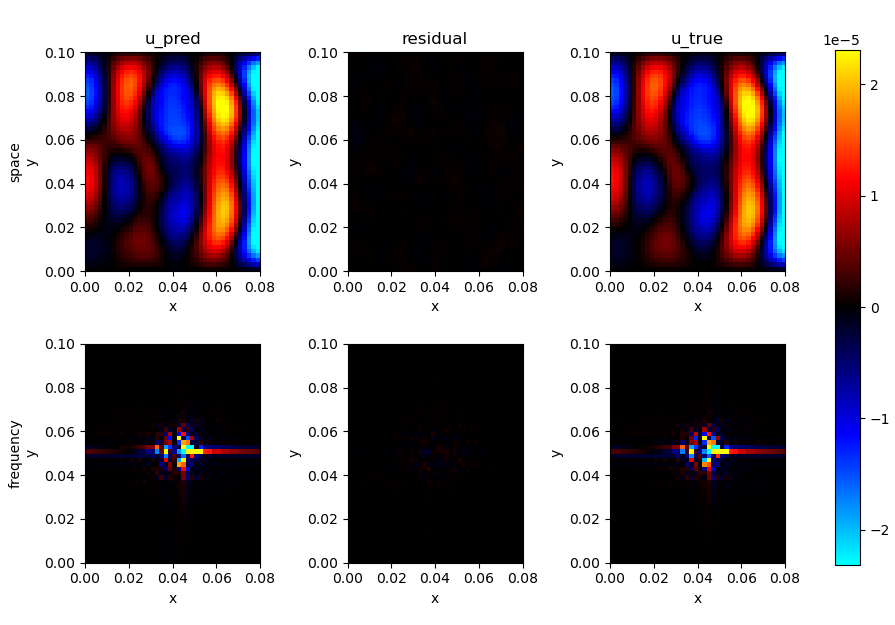

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


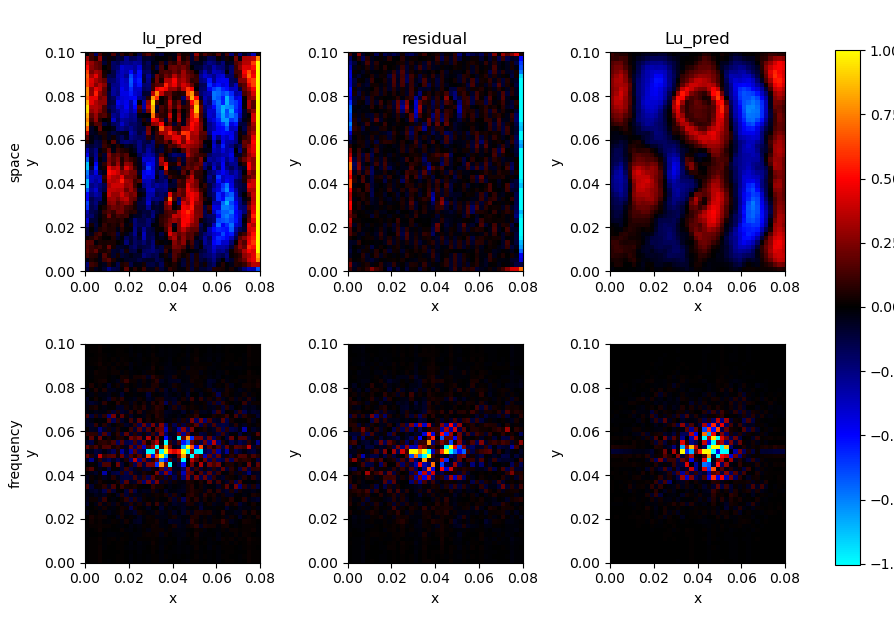

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


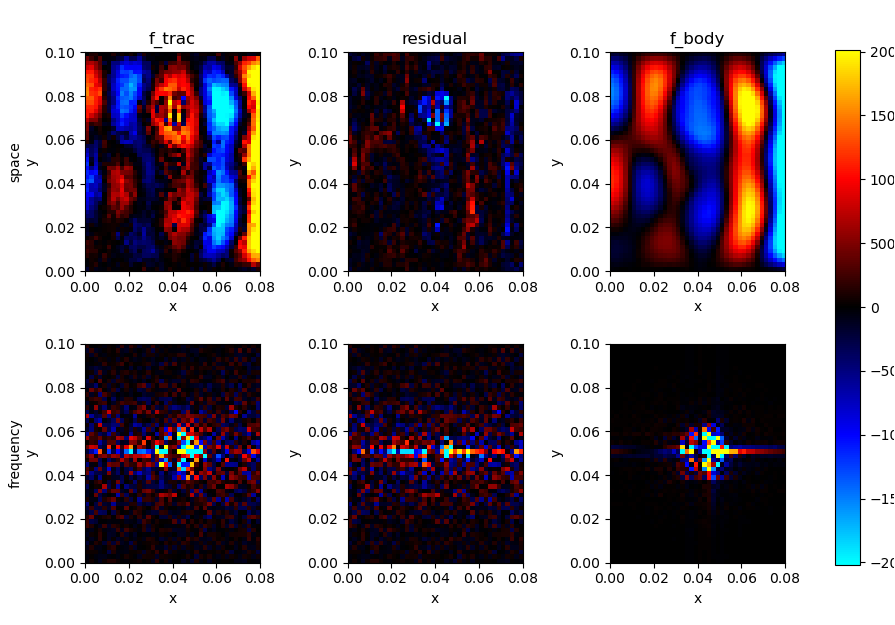

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


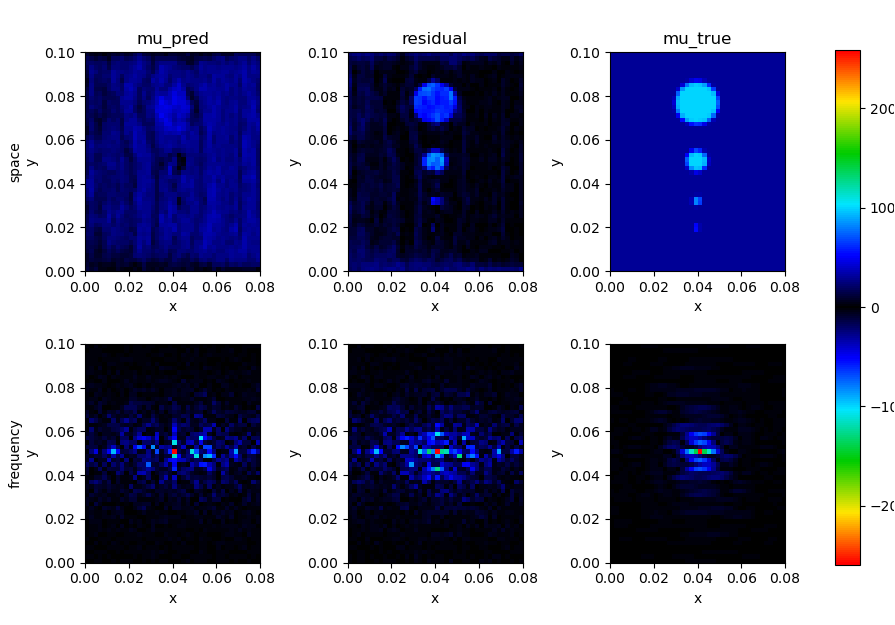

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…


Best model at step 97830:
  train loss: 1.84e-02
  test loss: 2.37e-02
  test metric: []

'train' took 8984.302132 s



In [79]:
%autoreload

model.compile(
    optimizer='adam',
    lr=1e-3,
    loss_weights=[1e-7, 1],
    loss=mre_pinn.training.normalized_l2_loss_fn(u)
)
deepxde.display.training_display = mre_pinn.visual.TrainingPlot(
    losses=['pde_loss', 'data_loss'], metrics=[]
)
callbacks = [
    mre_pinn.training.TestEvaluation(100, test_data, 128, row='domain', col='residual', dpi=20),
    mre_pinn.training.PDEResampler(period=1),
]
try:
    model.train(100000, display_every=10, callbacks=callbacks)
except KeyboardInterrupt as e:
    print('Interrupt', file=sys.stderr)

In [ ]:
# model predictions
x = u_bc.points
outputs = batch_predict(x)
u_pred, mu_pred = np.split(outputs, net.n_outputs[1:], axis=1)
u_pred = u_pred.reshape(u.shape)
mu_pred = mu_pred.reshape(mu.shape)

lu_pred = batch_predict(x, operator=laplacian_u)
lu_pred = lu_pred.reshape(u.shape)

u_pred  = mre_pinn.utils.as_xarray(u_pred,  like=u)
lu_pred = mre_pinn.utils.as_xarray(lu_pred, like=u)
mu_pred = mre_pinn.utils.as_xarray(mu_pred, like=mu)

In [ ]:
%autoreload

# display wave fields
mre_pinn.visual.XArrayViewer(
    xr.concat([u_pred, u - u_pred, u], dim='which'), y=y, hue='which', **wave_kws
)

In [ ]:
# display wave field Laplacians

Lu_true = mre_pinn.discrete.laplacian(u_true, resolution=1e-3, dim=1)
Lu_pred = mre_pinn.discrete.laplacian(u_pred, resolution=1e-3, dim=1)

mre_pinn.visual.XArrayViewer(
    xr.concat([lu_pred, lu_pred - Lu, Lu], dim='which'), y=y, hue='which', **laplace_kws
)

In [ ]:
%autoreload

# display reconstructed elastograms

omega = u.frequency.to_numpy().reshape(-1, 1, 1)
mu_data = mre_pinn.discrete.helmholtz_inversion(u, Lu_true, omega) #.mean(axis=0)
mu_u_Lu = mre_pinn.discrete.helmholtz_inversion(u_pred, Lu_pred, omega) #.mean(axis=0)
mu_u_lu = mre_pinn.discrete.helmholtz_inversion(u_pred, lu_pred, omega) #.mean(axis=0)
#mu_pred = mre_pinn.discrete.helmholtz_inversion(u_pred, lu_model, omega)

mre_pinn.visual.XArrayViewer(
    xr.concat([mu_pred, mu_pred - mu, mu], dim='which'), y=y, hue='which', **elast_kws
)

In [ ]:
# try out complex initialization schemes

def runiform(n, scale=1):
    return (2 * torch.rand(n) - 1) * scale

def cuniform(n, scale=1):
    radius = torch.rand(n) * scale 
    angle  = torch.rand(n) * 2 * np.pi
    return radius * torch.exp(1j * angle)

n = 10000
d = 2
layers = [16, 16, 16, 16]
sin = torch.sin
cis = lambda x: torch.cos(x) + 1j * torch.sin(x)
gas = lambda x: torch.exp(-x**2)
wav = lambda x: cis(x) * gas(x)

fig, axes = plt.subplots(len(layers) + 2, 2, figsize=(6, 1.5*(len(layers) + 2)), squeeze=False)

def plot_hist(ax, a):
    a = a.detach().cpu().numpy().flatten()
    if np.iscomplexobj(a):
        a = mre_pinn.utils.as_real(a, interleave=False)
    sns.histplot(a, bins=20, ax=ax, legend=True)

a = runiform((n, d))
b = runiform((n, d)) + 0j
plot_hist(axes[0,0], a)
plot_hist(axes[0,1], b)

for i, w in enumerate(layers):
    if i == 0:
        a_scale = 32 / d
        b_scale = 32 / d
    else:
        a_scale = np.sqrt(6 / d)
        b_scale = np.sqrt(6 / d)
    a = sin(a @ runiform((d, w), a_scale))
    b = cis(b @ cuniform((d, w), b_scale))
    plot_hist(axes[i+1,0], a)
    plot_hist(axes[i+1,1], b)
    d = w

a = a @ runiform((d, 1))
b = b @ cuniform((d, 1))
plot_hist(axes[-1,0], a)
plot_hist(axes[-1,1], b)
fig.tight_layout()